# Extended Data Figure 6 - Ye et al. 2023

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import json

plt.rcParams['axes.labelsize'] = 17  # for x and y labels
plt.rcParams['xtick.labelsize'] = 17 # for x axis tick labels
plt.rcParams['ytick.labelsize'] = 17 # for y axis tick labels
plt.rcParams['axes.titlesize'] = 17

In [2]:
with open('../data/Extended_Figure6/animalpose_train.json') as f:
    animalpose_obj = json.load(f)


with open('../data/Extended_Figure6/quadruped80k_train.json') as f:
    quadruped80k_obj = json.load(f)

with open('../data/Extended_Figure6/ap10k_train.json') as f:
    ap10k_obj = json.load(f)

with open('../data/Extended_Figure6/rodent_train.json') as f:
    rodent_obj = json.load(f)

with open('../data/Extended_Figure6/') as f:
    supertopview_obj = json.load(f)

with open('../data/Extended_Figure6/person_keypoints_train2014.json') as f:
    coco_obj = json.load(f)

In [3]:
def plot_multiple_relative_areas(objs, names):


    fig, axes = plt.subplots(2, 3, figsize = (12,6), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
    plt.subplots_adjust(hspace=0.4)
    for i in range(len(objs)):
        name = names[i]
        obj = objs[i]
        imageid2imagearea = {}

        for image in obj['images']:
            h, w = image['height'], image['width']
            area= w * h
            imageid2imagearea[image['id']] = area
            areas = []

        for anno in obj['annotations']:
            x1,y1,w,h = anno['bbox']
            area =  w*h
            try:
                image_area = imageid2imagearea[anno['image_id']]
            except:
                continue
            areas.append(area/image_area)
        areas = np.array(areas)
        row = i // 3
        col = i % 3
        axes[row][col].hist(areas, bins=30, edgecolor='black')
        axes[row][col].spines[['right', 'top']].set_visible(False)
        axes[row][col].set_title(names[i])

    plt.savefig('relative_ratio.png', dpi = 300, transparent = True)



def plot_multiple_absolute_areas(objs, names):


    fig, axes = plt.subplots(2, 3, figsize = (12,6), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
    plt.subplots_adjust(hspace=0.4)
    for i in range(len(objs)):
        name = names[i]
        obj = objs[i]
        areas = []
        for anno in obj['annotations']:
            x1,y1,w,h = anno['bbox']
            area =  w*h
            areas.append(area/1000)
        areas = np.array(areas)
        row = i // 3
        col = i % 3
        axes[row][col].set_xlim(0,2500)
        axes[row][col].hist(areas, bins=30, edgecolor='black')
        axes[row][col].spines[['right', 'top']].set_visible(False)
        axes[row][col].set_title(names[i])

    plt.savefig('absolute_size.png', dpi = 300, transparent = True)


## Relative animal size in common pose datasets

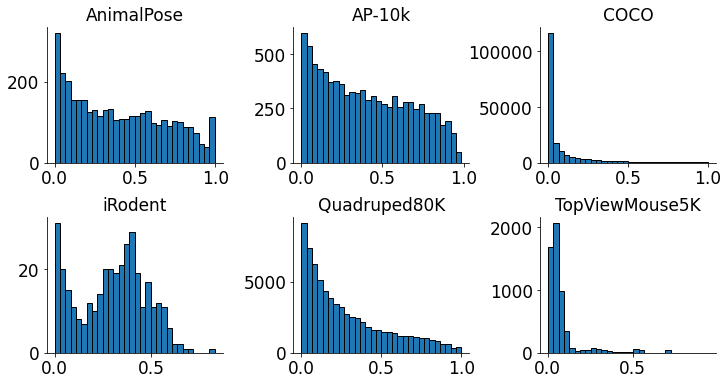

In [7]:
objs = [animalpose_obj, ap10k_obj, coco_obj,   rodent_obj, quadruped80k_obj, supertopview_obj]

names = ['AnimalPose',
         'AP-10k',
         'COCO',
         'iRodent',
         'Quadruped80K',
         'TopViewMouse5K']

plot_multiple_relative_areas(objs, names)


## Absolute animal sizes in common pose datasets

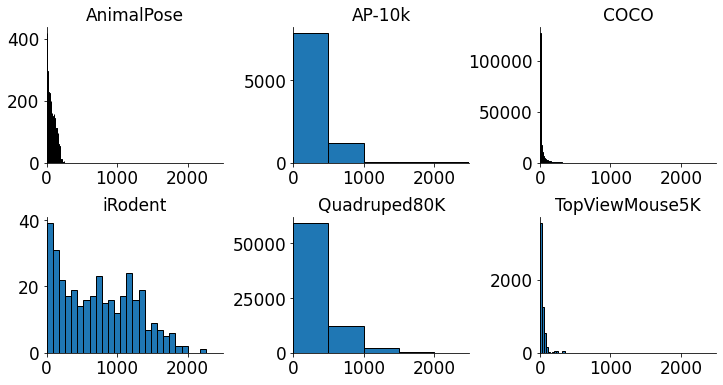

In [6]:
plot_multiple_absolute_areas(objs, names)


## With and without spatial pyramid adaptation on OOD mice datasets, evaluated in terms of RMSE

/var/folders/n5/5_x4w2px2wn6hc6n_9zzlygw0000gn/T/ipykernel_87422/3291278308.py:15: RuntimeWarning: Mean of empty slice
  with_spatial_pyramid = np.nanmean(pickle_obj[proj_root]['with_spatial_pyramid']['RMSE'], axis=(1, 2))
/var/folders/n5/5_x4w2px2wn6hc6n_9zzlygw0000gn/T/ipykernel_87422/3291278308.py:17: RuntimeWarning: Mean of empty slice
  without_spatial_pyramid = np.nanmean(pickle_obj[proj_root]['without_spatial_pyramid']['RMSE'], axis=(1, 2))


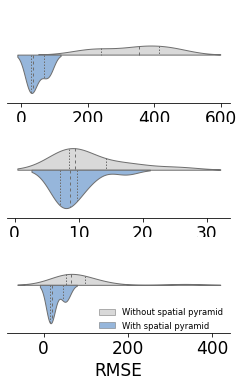

In [5]:
def plot_OOD_spatial_pyramid_RMSE():
    # %%
    with open('../data/Figure3/ood_mice_zeroshot.pickle', 'rb') as f:
        pickle_obj = pickle.load(f)
    # %%
    proj_roots = list(pickle_obj.keys())
    proj_nicknames = ['smear mouse', 'ood maushaus', 'golden mouse']
    method_colors = plt.cm.get_cmap('magma_r', 6)

    fig, axes = plt.subplots(3, figsize=(4, 6))

    remove_nan = lambda x: x[~np.isnan(x)]
    dfs = []
    for i, proj_root in enumerate(pickle_obj):
        with_spatial_pyramid = np.nanmean(pickle_obj[proj_root]['with_spatial_pyramid']['RMSE'], axis=(1, 2))
        with_spatial_pyramid = remove_nan(with_spatial_pyramid)
        without_spatial_pyramid = np.nanmean(pickle_obj[proj_root]['without_spatial_pyramid']['RMSE'], axis=(1, 2))
        without_spatial_pyramid = remove_nan(without_spatial_pyramid)
        with_pyramid = ["without"] * len(without_spatial_pyramid) + ["with"] * len(with_spatial_pyramid)
        df_ = pd.DataFrame(
            np.array([
                np.r_[without_spatial_pyramid, with_spatial_pyramid],
                with_pyramid,
            ]).T,
            columns=['RMSE', 'cond'])
        df_['dataset'] = proj_nicknames[i]
        df_['RMSE'] = df_['RMSE'].astype("float64")
        df_['cond'] = df_['cond'].astype("category")
        df_['dataset'] = df_['dataset'].astype("category")
        dfs.append(df_)
        vp = sns.violinplot(
            df_, y='dataset', x='RMSE', hue='cond', split=True, hue_order=['without', 'with'],
            inner="quart", linewidth=1, palette={"without": ".85", "with": "#8AB5E7"},
            ax=axes[i], bw='scott',
        )
        sns.despine(ax=axes[i], left=True, top=True, right=True)
        axes[i].set_yticks([])
        axes[i].set_ylabel("")
        # axes[i].set_xlim(left=0)
    for i in (0, 1):
        axes[i].legend().remove()
    handles, labels = axes[2].get_legend_handles_labels()
    fig.legend(
        handles,
        ['Without spatial pyramid', 'With spatial pyramid'],
        frameon=False,
        ncol=1,
        # loc='lower right',
        fontsize='small',
        bbox_to_anchor=(0.9, 0.2),
    )
    axes[2].legend().remove()
    fig.savefig('Figure3c.png', dpi=600, bbox_inches='tight', pad_inches=0.05)


plot_OOD_spatial_pyramid_RMSE()